In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [6]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [8]:
events_data.date.describe()

count                 3480703
unique                2196932
top       2016-10-12 20:25:38
freq                       21
first     2015-06-15 04:00:48
last      2018-05-19 23:33:31
Name: date, dtype: object

In [9]:
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


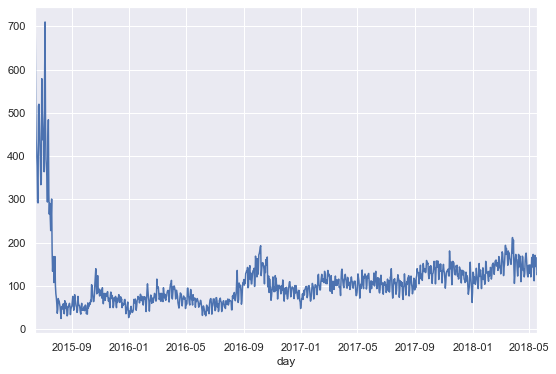

In [10]:
events_data.groupby('day') \
    .user_id.nunique().plot();

In [11]:
events = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [12]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [13]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [14]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [15]:
gap_data = gap_data / (24 * 60 * 60)

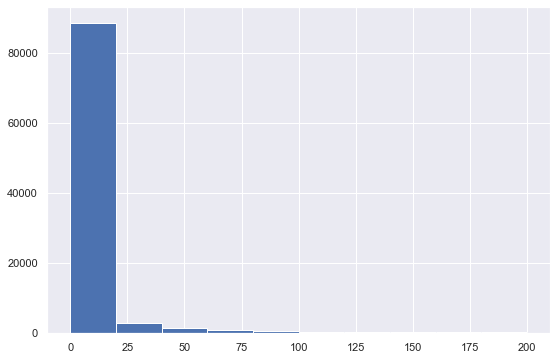

In [16]:
gap_data[gap_data < 200].hist()

In [17]:
gap_data.quantile(0.95)

59.760440972222156

In [18]:
gap_data.quantile(0.90)

18.325995370370403

In [19]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [20]:
users_scores.sort_values(by='correct', ascending=False).head()

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42


In [21]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [22]:
now = 1526772811
threshold = 30 * 24 * 60 * 60

In [23]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > threshold

In [24]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [25]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [26]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [27]:
users_data = users_data.merge(events, how='outer', on='user_id')

In [28]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [29]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,NaN,NaN,1,1,0,1


In [30]:
users_data.merge(users_days, how='outer', on='user_id').head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,NaN,NaN,1,1,0,1,1


In [31]:
users_data = users_data.merge(users_days, how='outer', on='user_id')

In [32]:
users_data.user_id.nunique()

19234

In [33]:
events_data.user_id.nunique()

19234

In [34]:
users_data['passed_course'] = users_data.passed > 170

In [35]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,NaN,NaN,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,NaN,NaN,1,1,0,1,1,False


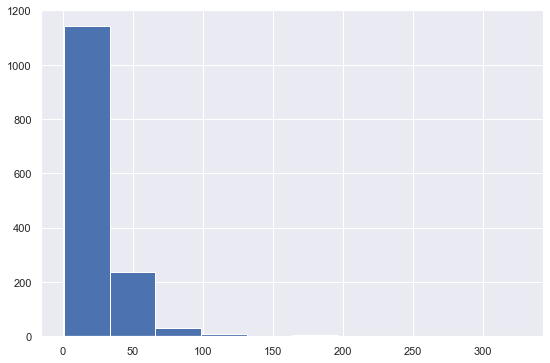

In [37]:
users_data[users_data.passed_course].day.hist();

In [38]:
users_data[users_data.passed_course].day.median()

20.0

In [44]:
min_date_time = events_data.groupby('user_id', as_index=False) \
        .agg({'timestamp': 'min'}) \
        .rename({'timestamp': 'min_timestamp'}, axis=1)

In [45]:
users_data = users_data.merge(min_date_time, how='outer')

In [72]:
%timeit events_data.groupby(['user_id']).apply(lambda x: x.timestamp < (x.timestamp.min() + 3 * 24 * 3600))

14.3 s ± 835 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%timeit events_data[ \
    events_data['timestamp'] < events_data \
    .merge(users_data[['user_id', 'min_timestamp']], how='left') \
    .min_timestamp + 3 * 24 * 60 * 60]

782 ms ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
events_data['timestamp']

0          1434340848
1          1434340848
2          1434340848
3          1434340895
4          1434340895
5          1434340895
6          1434340921
7          1434340921
8          1434340939
9          1434340944
10         1434340950
11         1434340950
12         1434340950
13         1434340991
14         1434340991
15         1434341016
16         1434341039
17         1434341044
18         1434341044
19         1434341044
20         1434341063
21         1434341063
22         1434341063
23         1434341098
24         1434341098
25         1434341098
26         1434341107
27         1434341107
28         1434341107
29         1434341195
              ...    
3480673    1526770532
3480674    1526770543
3480675    1526770556
3480676    1526771227
3480677    1526771246
3480678    1526771246
3480679    1526771246
3480680    1526771250
3480681    1526771250
3480682    1526771250
3480683    1526771579
3480684    1526771742
3480685    1526771881
3480686    1526771888
3480687   

In [76]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [95]:
submissions_data[submissions_data.user_id == 10995]

,step_id,timestamp,submission_status,user_id,date,day
509075,120745,1477610269,wrong,10995,2016-10-27 23:17:49,2016-10-27
509076,120745,1477610306,correct,10995,2016-10-27 23:18:26,2016-10-27


In [101]:
submissions_data.query("submission_status == 'wrong'").groupby('step_id').count().sort_values(ascending = False, by='user_id')

,timestamp,submission_status,user_id,date,day
step_id,,,,,
31978,16084,16084,16084,16084,16084
32031,13373,13373,13373,13373,13373
32202,13002,13002,13002,13002,13002
33481,10300,10300,10300,10300,10300
32075,10003,10003,10003,10003,10003
32206,9388,9388,9388,9388,9388
31972,8960,8960,8960,8960,8960
32174,7778,7778,7778,7778,7778
32809,7748,7748,7748,7748,7748


In [103]:
events_data = events_data[ \
    events_data['timestamp'] < events_data \
    .merge(users_data[['user_id', 'min_timestamp']], how='left') \
    .min_timestamp + 3 * 24 * 60 * 60]

In [104]:
events_data.groupby('user_id').day.nunique().max()

4

In [105]:
submissions_data = submissions_data[ \
    submissions_data['timestamp'] < submissions_data \
    .merge(users_data[['user_id', 'min_timestamp']], how='left') \
    .min_timestamp + 3 * 24 * 60 * 60]

In [106]:
submissions_data.groupby('user_id').day.nunique().max()

4

In [131]:
X = submissions_data.groupby('user_id').day.nunique().to_frame().reset_index() \
        .rename(columns={'day':'days'})

In [132]:
step_tried = submissions_data.groupby('user_id').step_id.nunique().to_frame().reset_index() \
        .rename(columns={'step_id':'step_tried'})

In [133]:
X = X.merge(step_tried, on='user_id', how='outer')

In [134]:
X.head()

,user_id,days,step_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [135]:
X = X.merge(submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [136]:
X.head()

,user_id,days,step_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [137]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [138]:
X.head()

,user_id,days,step_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [139]:
X = X.merge(events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [140]:
X.fillna(0, inplace=True)

In [146]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [149]:
X = X[X.is_gone_user | X.passed_course]

In [150]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [160]:
y = X.passed_course


AttributeError: 'DataFrame' object has no attribute 'passed_course'

In [162]:
y = y.map(int)

In [152]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)

In [153]:
X.head()

,user_id,days,step_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [154]:
X.set_index(X.user_id, inplace=True)

In [155]:
X.head()

,user_id,days,step_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,,
2,2,1.0,2.0,2.0,0.0,1.00,9
3,3,1.0,4.0,4.0,4.0,0.50,20
8,8,1.0,11.0,9.0,21.0,0.30,154
14,14,1.0,1.0,0.0,1.0,0.00,9
16,16,3.0,23.0,23.0,27.0,0.46,132


In [157]:
X.drop(['user_id'], axis=1, inplace=True)

In [163]:
X.head()

,days,step_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
